In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *
from scipy.signal.windows import dpss
import sys

Lambda_idx = 24
# Lambda_idx = int(sys.argv[1])
Lambda = Lambdas[Lambda_idx]

# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)


# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

In [2]:
from scipy.interpolate import interp1d, interp2d, LinearNDInterpolator

inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')
from scipy.integrate import quad, quad_vec, trapezoid

In [3]:
tmp_chibs = []
tmp_log_deltas = []
tmp_fnctn = []
for i in range(len(chibs)):
    for j in range(len(deltas)):
        tmp_chibs += [chibs[i]]
        tmp_log_deltas += [np.log10(deltas[j])]
        tmp_fnctn += [inner_dkparp_integral[:,i,j]]
        
f_inner_integral = LinearNDInterpolator(list(zip(tmp_chibs, tmp_log_deltas)), tmp_fnctn)

In [4]:
from tqdm import trange

In [5]:
2**10

1024

In [6]:
n_external = 1000
n_chibs = 2**10



external_chis     =  np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
print('external chi spacing', np.mean(np.diff(external_chis)))
cross = np.zeros((100, n_external, n_external), dtype=np.float64)


print('chib spacing', (chimax - chimin)/(2 * (n_chibs - 1)))


for chi_idx in trange(n_external):
    chi = external_chis[chi_idx]
    chip = external_chis
    
    _chibs = np.linspace((chimin + chi)/2, (chimax + chi)/2, n_chibs)

    f_KLIMLo = get_f_KILo(external_chi = chip.reshape(n_external, 1), Lambda=Lambda)
    f_KLIMLo_windowed = apply_window(f_K = f_KLIMLo,
                                     chimin = chimin,
                                     chimax = chimax)

    _deltas = np.abs(1 - chi/_chibs)

    integrand = 2 * f_KLIM_windowed(chi)
    _deltas = np.where(_deltas > 0.7, 0.7, _deltas)
    _deltas = np.where(_deltas < 1e-6, 1e-6, _deltas)
    integrand *= f_inner_integral(list(zip(_chibs, np.log10(_deltas))))
    integrand /= (_chibs**2).reshape(n_chibs, 1)
    kernel = f_KLIMLo_windowed((2*_chibs - chi).reshape(1, n_chibs))
    #b = chib
    #l = ell
    #p = chip
    integrand = np.einsum('bl, pb-> lpb', integrand, kernel)
    cross[:,chi_idx,:] = trapezoid(x = _chibs, y = integrand)

external chi spacing 2.2117496122655558
chib spacing 1.0799306080270594


100%|██████████| 1000/1000 [15:24<00:00,  1.08it/s]


In [18]:
f_inner_integral(list(zip(_chibs, np.log10(_deltas)))).shape

(1024, 100)

In [19]:
_deltas.shape

(1024,)

In [7]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [8]:
for ell_idx in range(len(ells)):
    print(check_symmetric(cross[ell_idx]))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [9]:
cross = cross + np.moveaxis(cross, -1, -2) # the two cross terms are just from switching chi and chi'

In [10]:
vb = np.max(np.abs(cross[0]))

In [11]:
print(vb)

1.9119649337991045e-05


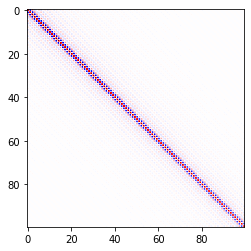

In [12]:
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, zmax, Lambda_idx, 100)
cov = Pei * np.load(oup_fname)
vb = np.max(np.abs(cov))
plt.imshow(cov, vmin = -vb, vmax = vb, cmap='seismic')

In [13]:
cross.shape

(100, 1000, 1000)

In [14]:
nbins = 100
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), nbins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
cross_binned = np.zeros((100, nbins,nbins), dtype=np.float64)

for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
    for j, (l2, r2) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
        idx2 = np.where((external_chis > l2) & (external_chis <= r2))[0]
        cross_binned[:, i,j] = np.sum(cross[:,idx1[0]:idx1[-1]+1,idx2[0]:idx2[-1]+1], axis=(-1, -2)) / len(idx1) / len(idx2)

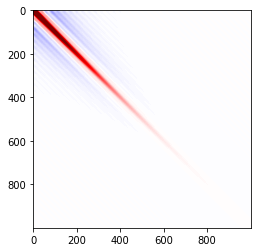

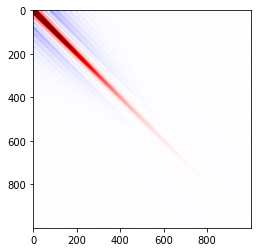

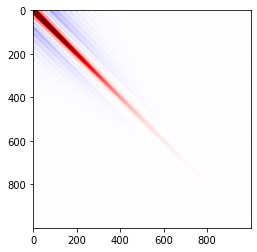

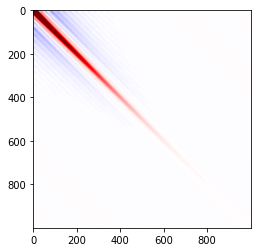

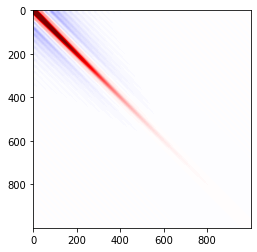

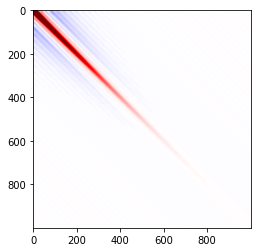

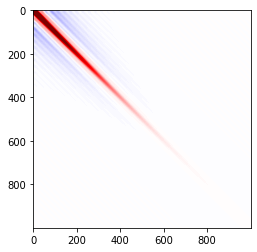

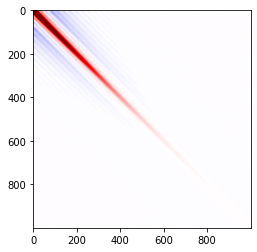

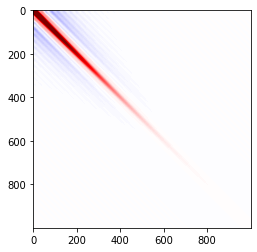

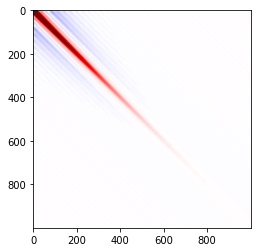

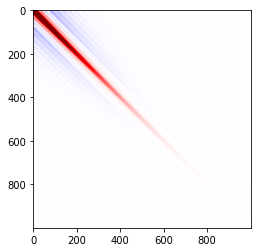

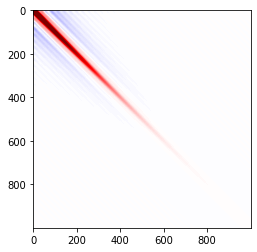

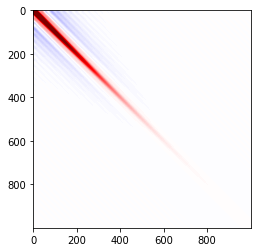

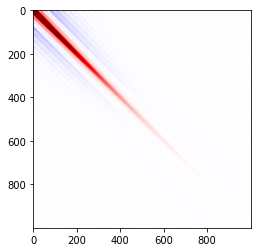

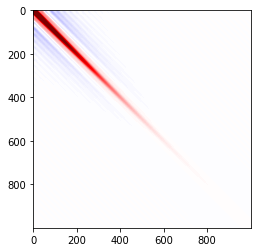

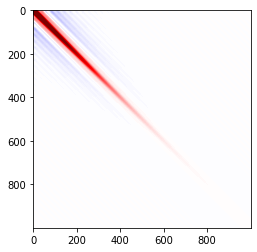

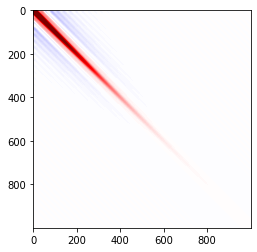

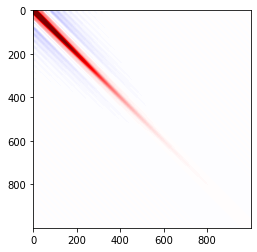

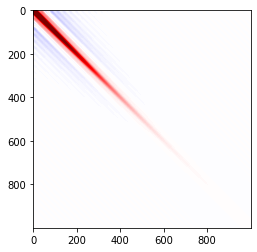

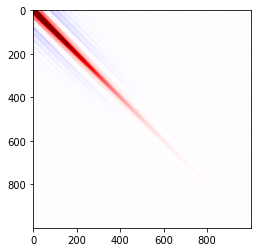

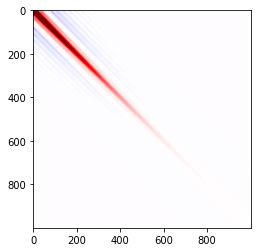

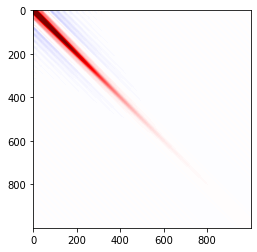

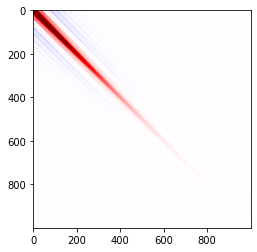

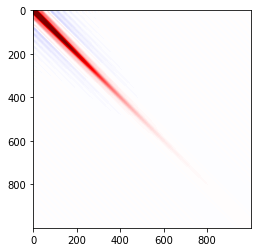

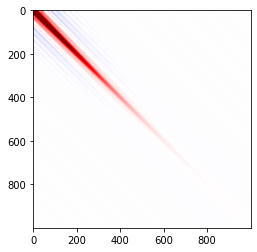

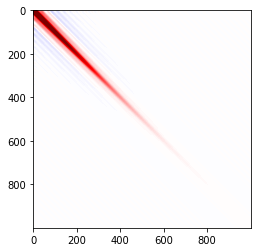

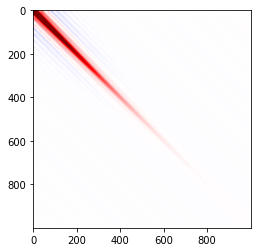

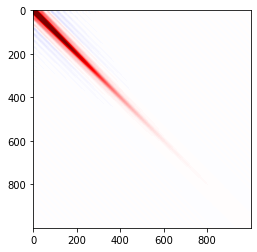

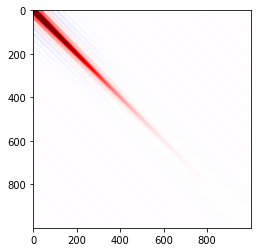

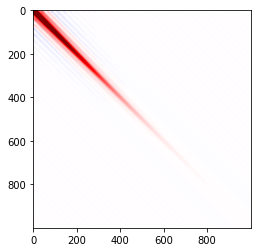

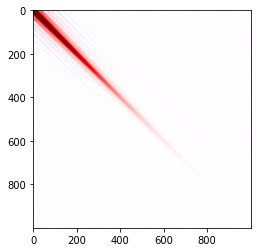

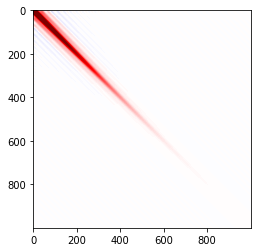

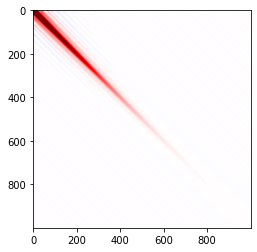

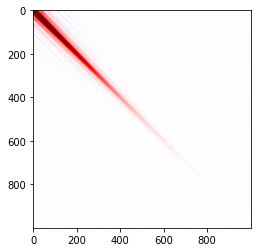

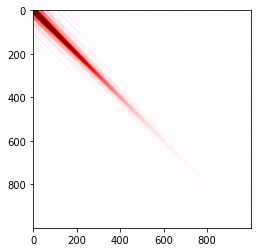

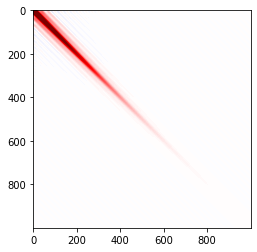

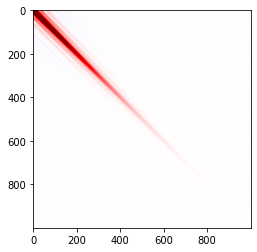

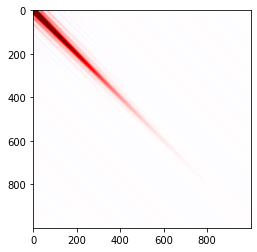

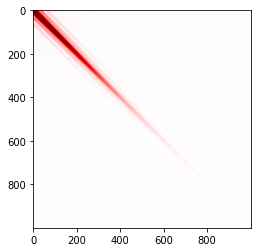

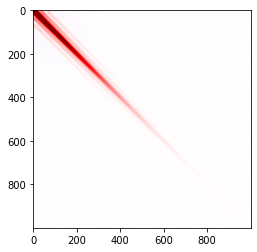

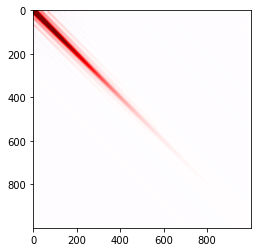

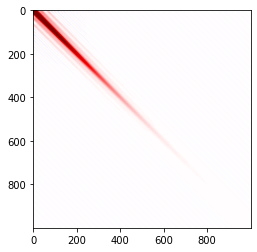

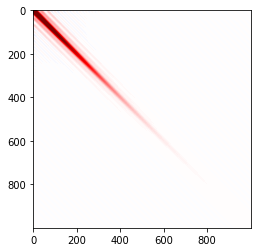

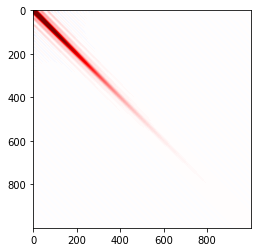

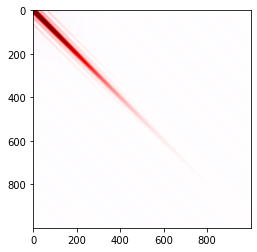

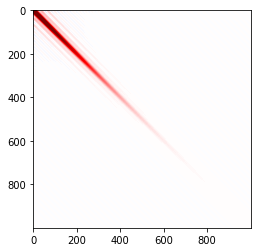

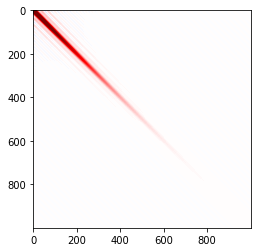

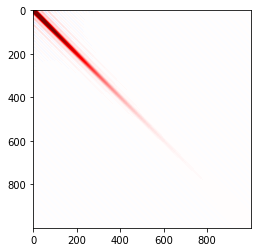

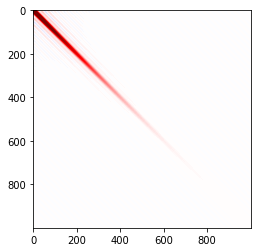

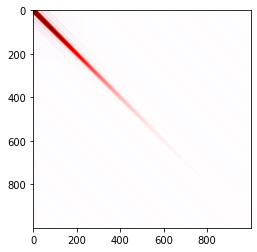

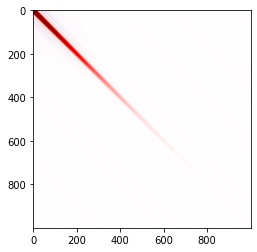

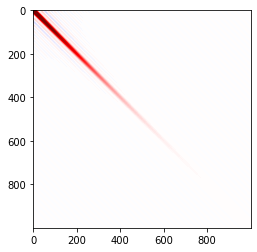

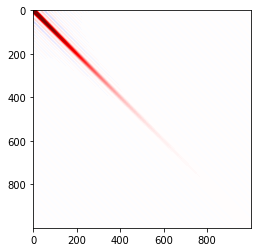

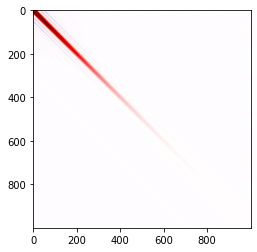

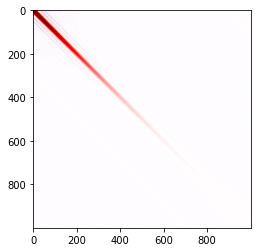

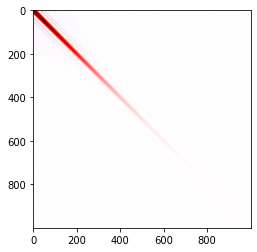

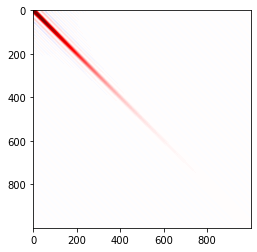

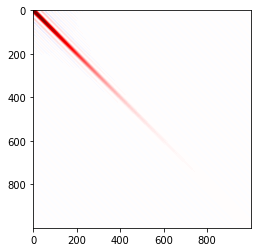

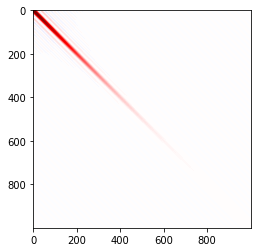

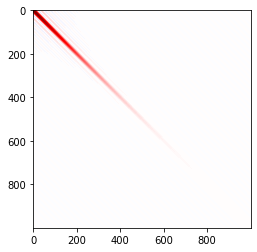

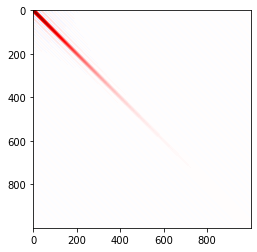

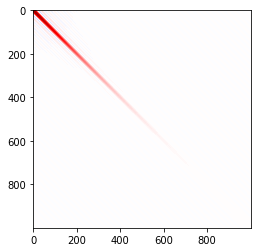

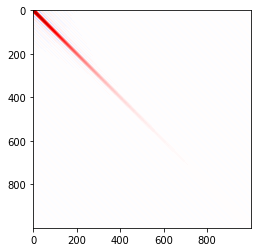

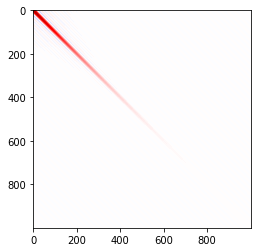

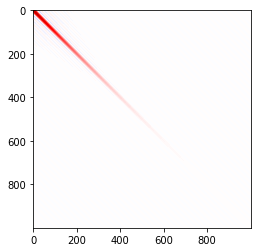

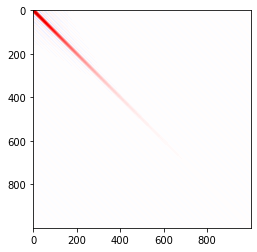

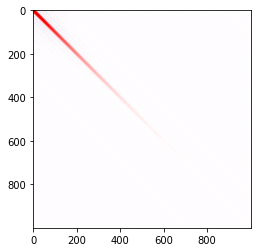

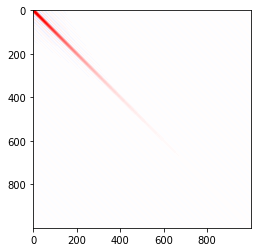

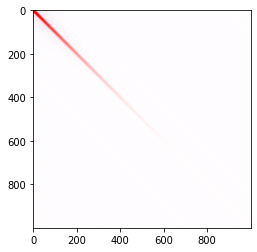

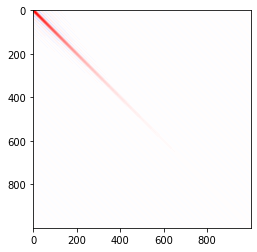

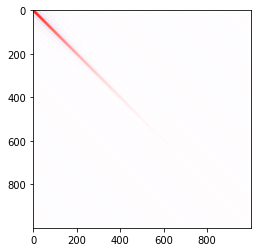

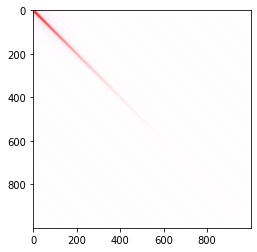

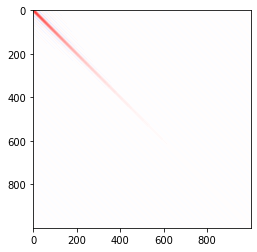

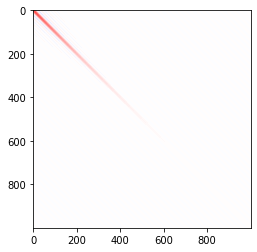

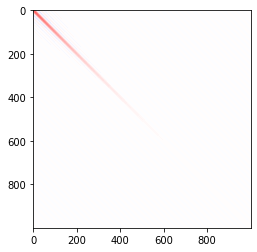

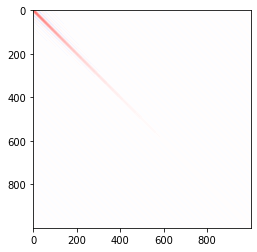

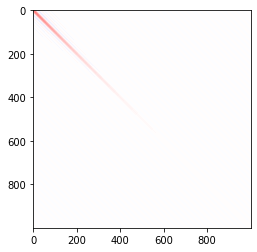

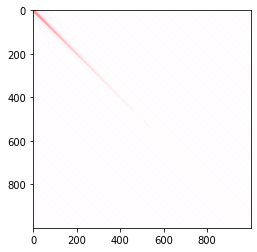

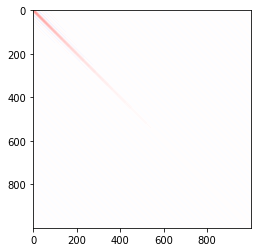

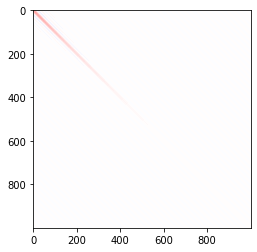

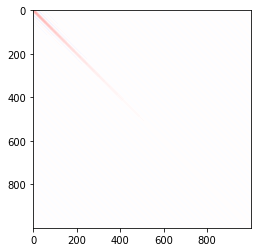

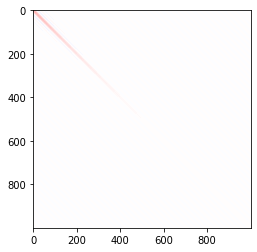

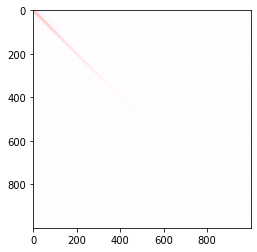

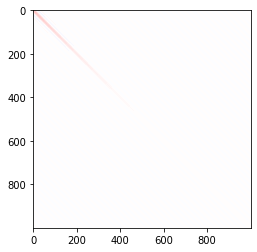

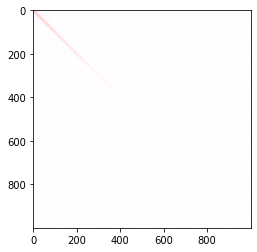

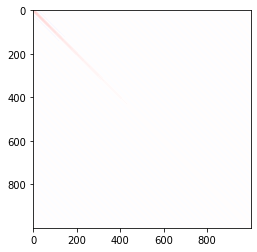

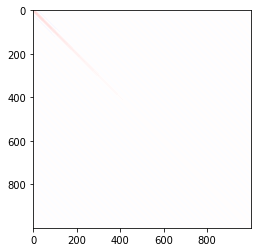

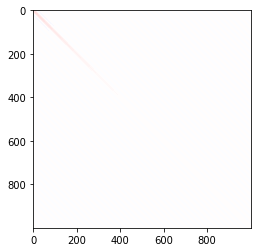

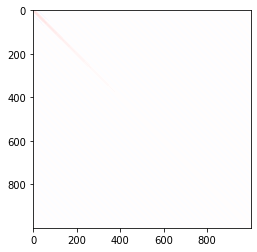

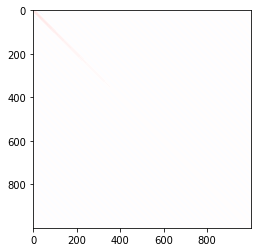

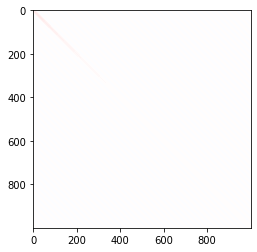

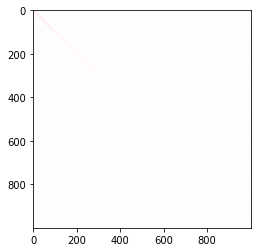

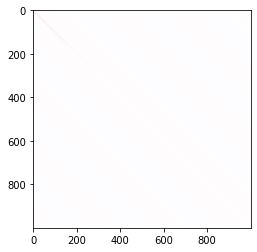

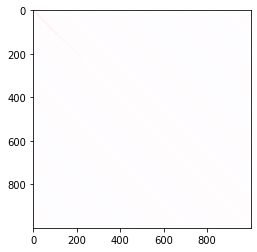

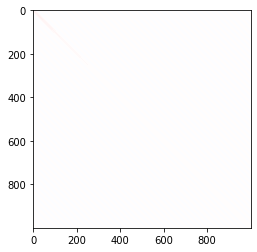

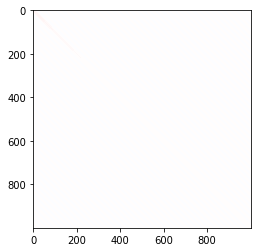

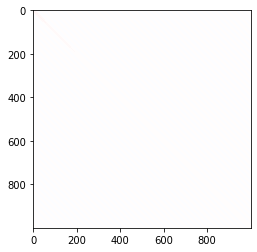

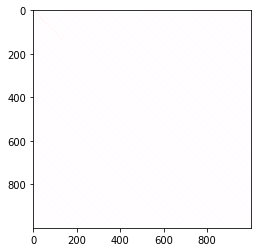

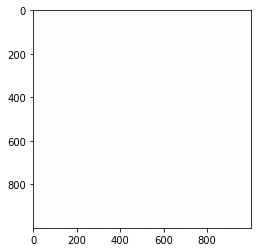

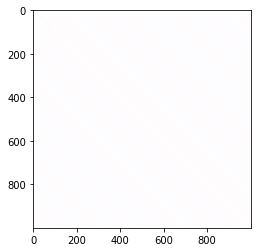

In [15]:
for ell_idx in range(len(ells)):
    
    plt.imshow(cross[ell_idx], vmin = -vb, vmax = vb, cmap = 'seismic')
    assert(check_symmetric(cross[ell_idx]))
    plt.show()

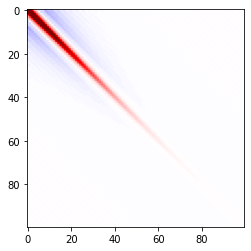

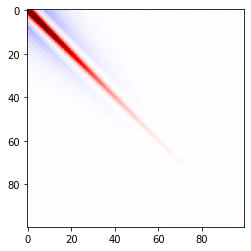

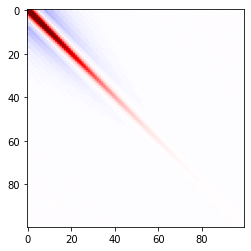

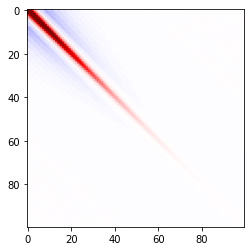

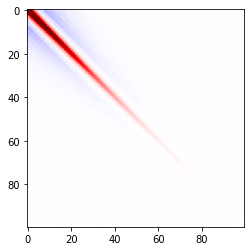

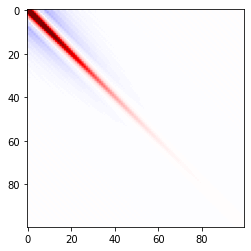

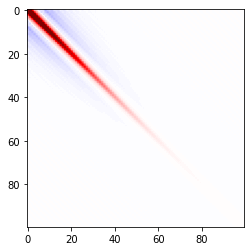

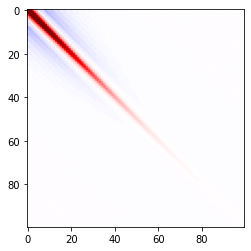

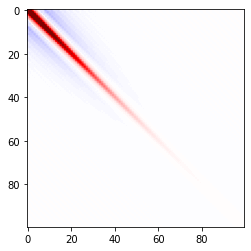

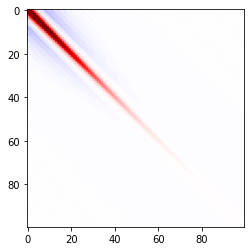

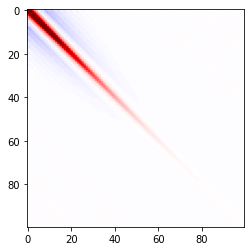

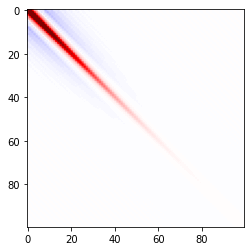

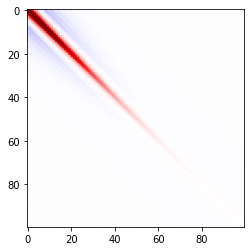

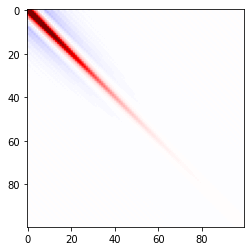

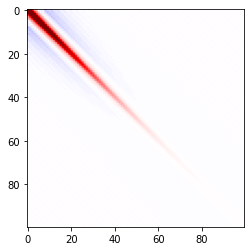

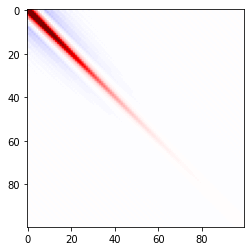

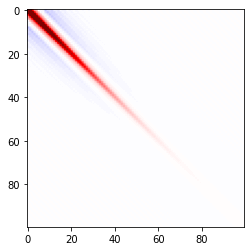

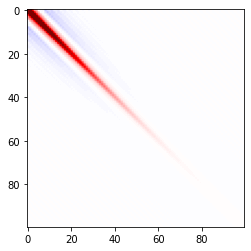

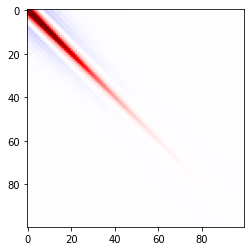

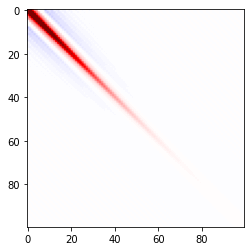

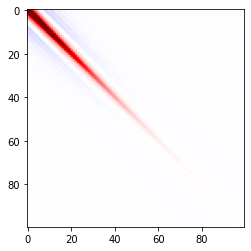

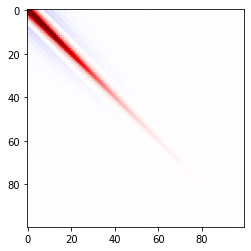

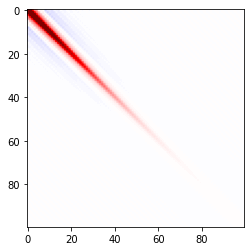

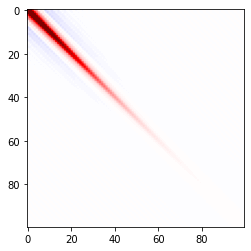

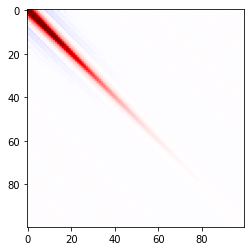

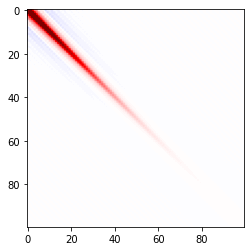

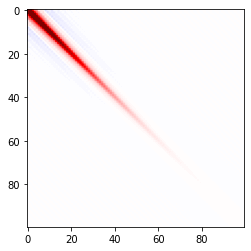

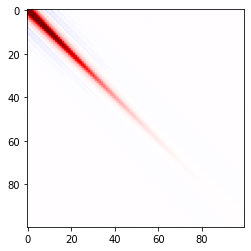

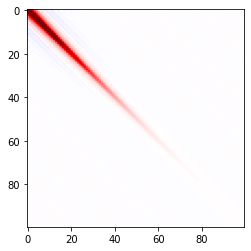

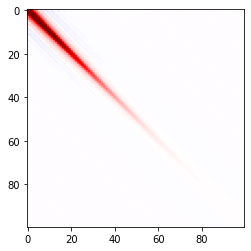

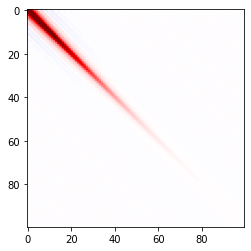

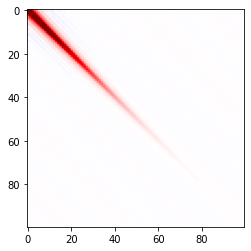

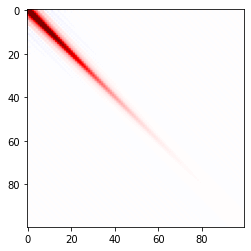

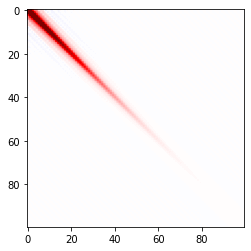

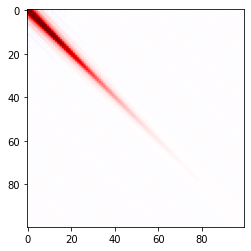

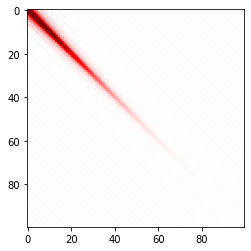

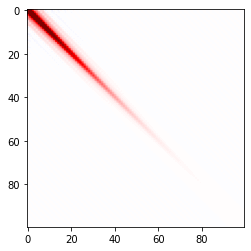

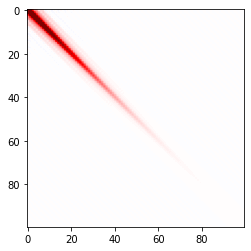

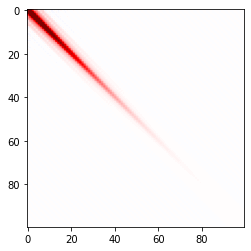

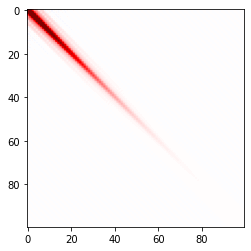

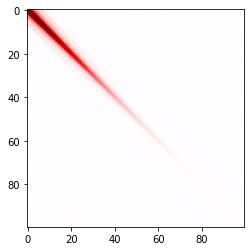

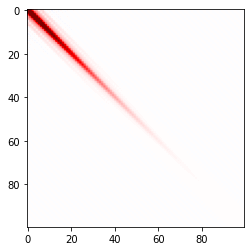

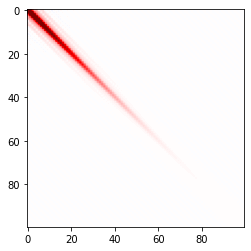

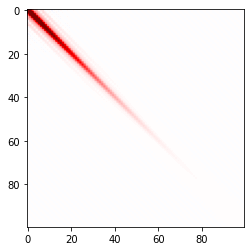

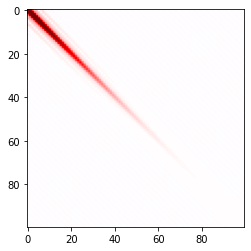

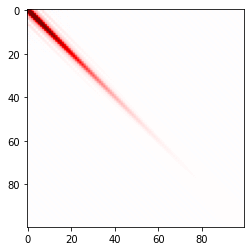

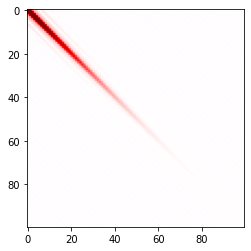

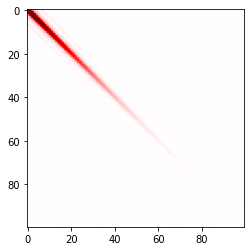

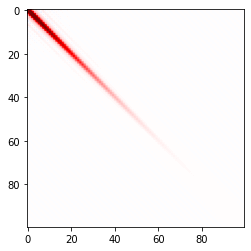

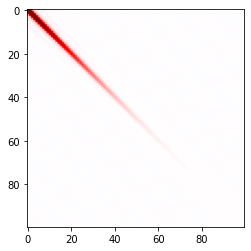

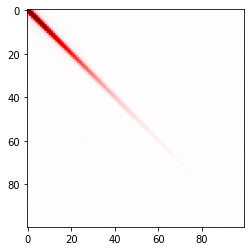

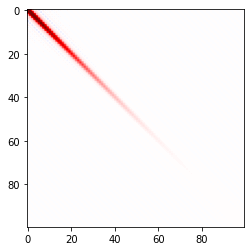

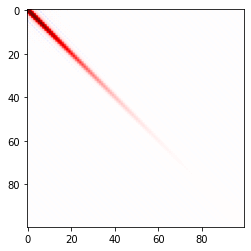

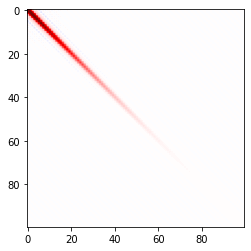

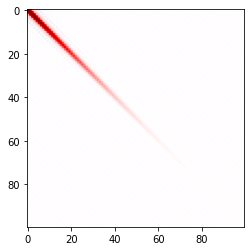

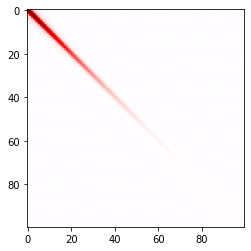

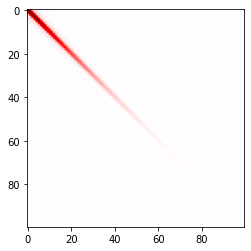

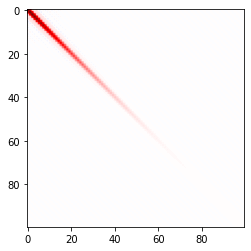

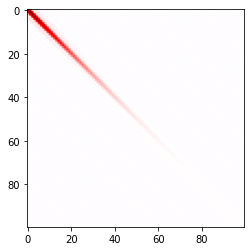

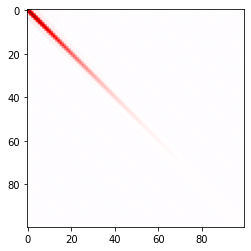

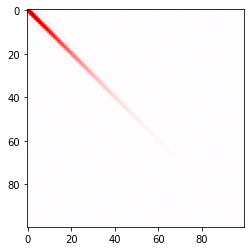

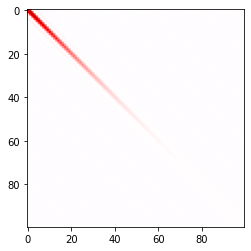

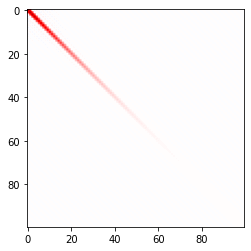

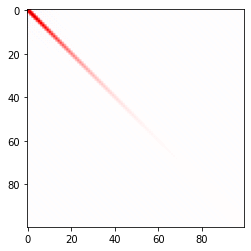

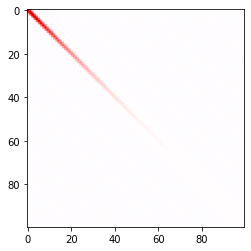

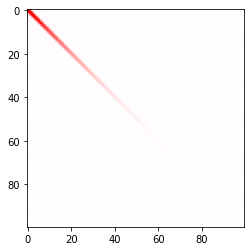

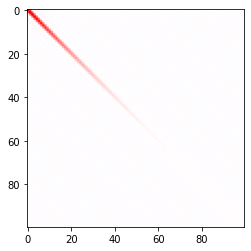

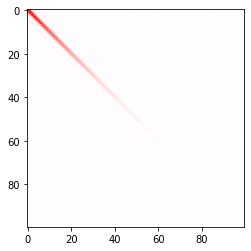

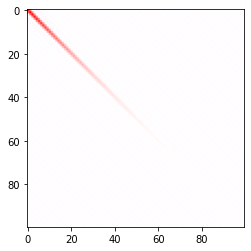

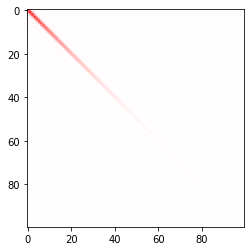

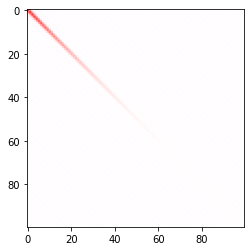

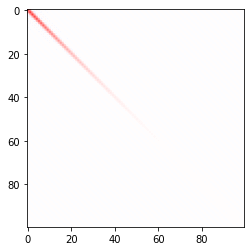

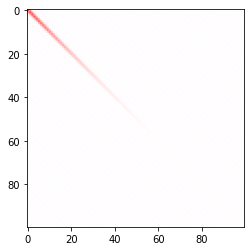

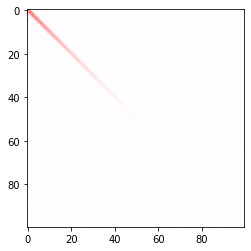

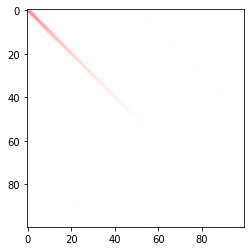

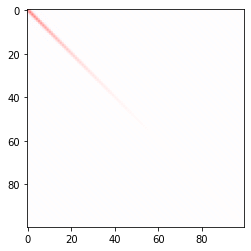

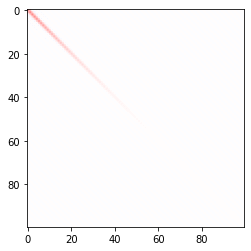

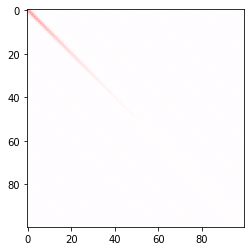

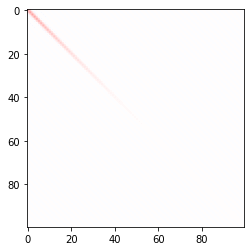

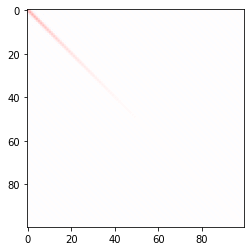

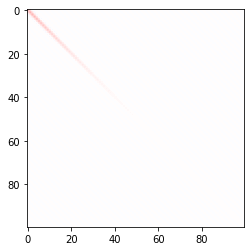

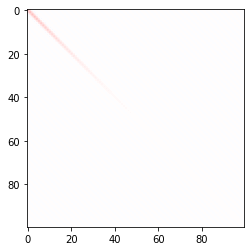

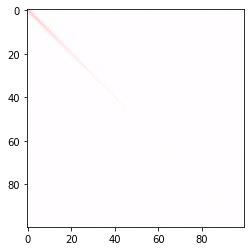

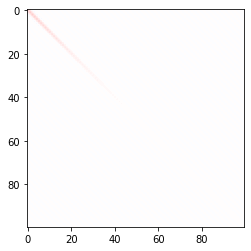

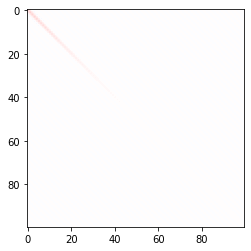

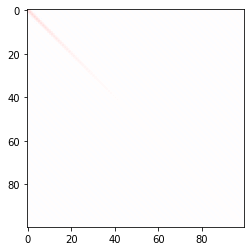

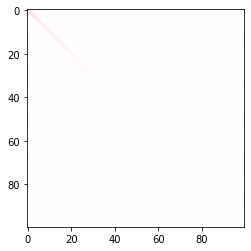

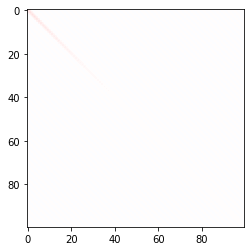

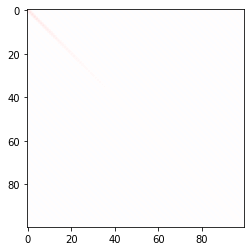

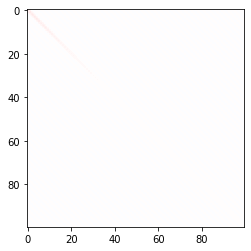

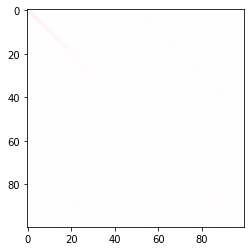

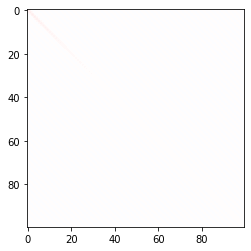

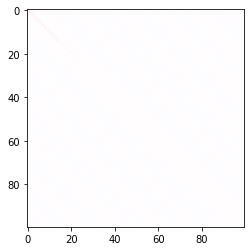

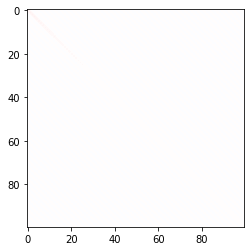

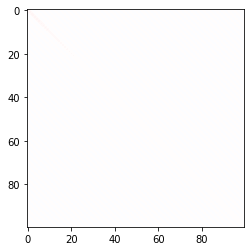

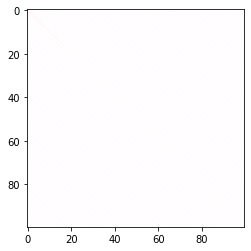

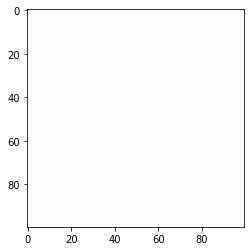

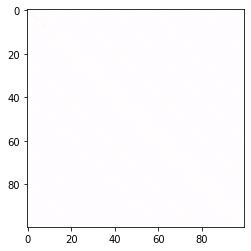

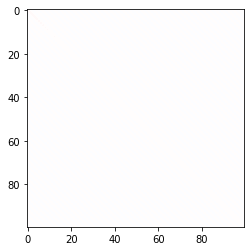

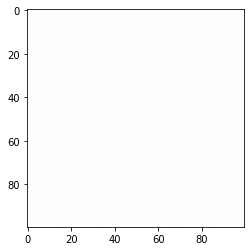

In [16]:
for ell_idx in range(len(ells)):
    
    plt.imshow(cross_binned[ell_idx], vmin = -vb, vmax = vb, cmap = 'seismic')
    assert(check_symmetric(cross[ell_idx]))
    plt.show()

In [23]:
2**15

32768